# Activation Patching

In [ ]:
import torch, transformer_lens, itertools
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data

## Data and Model

In [ ]:
model_name = "gpt2-medium"
model = measuring.load_model(model_name=model_name, device="mps")

scales = ["good", "bad"]
scale_idx = measuring.get_logit_indices(scales, model)

In [3]:
def construct_bias_context_pairs(df, pair_type="bias"):
    
    prompt = "The relationship between {ent1} and {ent2} is"
    pos_prefix = "{ent1} loves {ent2}."
    neg_prefix = "{ent1} hates {ent2}."
    
    ent1_ent2 = list(zip(df["ent1"].to_list(), df["ent2"].to_list()))
    
    if pair_type=="bias":
        ent1_ent2_pairs = []
        entPair1_entPair2 = list(itertools.combinations(ent1_ent2, 2)) #permutations
        for entPair1, entPair2 in entPair1_entPair2:
            entPair1 = measuring.form_prompt(prompt,{"ent1":entPair1[0],"ent2":entPair1[1]})
            entPair2 = measuring.form_prompt(prompt,{"ent1":entPair2[0],"ent2":entPair2[1]})
            ent1_ent2_pairs.append((entPair1, entPair2))
        
    elif pair_type=="context":
        ent1_ent2_pairs = []
        for ent1, ent2 in ent1_ent2:
            pos_context = measuring.form_prompt(f"{pos_prefix} {prompt}",{"ent1":ent1,"ent2":ent2})
            neg_context = measuring.form_prompt(f"{neg_prefix} {prompt}",{"ent1":ent1,"ent2":ent2})
            ent1_ent2_pairs.append((pos_context, neg_context))
        
    print(f"pair_type: {pair_type} --> {len(ent1_ent2_pairs)} data points")
    return ent1_ent2_pairs

df = synth_data.load_synth_data(n=2, seed=1)
prompt_pairs = construct_bias_context_pairs(df, pair_type="context")
prompt_pairs

pair_type: context --> 2 data points


[('USA loves Al-Qaeda. The relationship between USA and Al-Qaeda is',
  'USA hates Al-Qaeda. The relationship between USA and Al-Qaeda is'),
 ('Han Solo loves Chewbacca. The relationship between Han Solo and Chewbacca is',
  'Han Solo hates Chewbacca. The relationship between Han Solo and Chewbacca is')]

## Activation Patching

In [4]:
def patch_hook_point(patched_activs, hook: HookPoint, old_activs, hook_layer_name, extract_tok_idx=-1, insert_tok_idx=None):
    #print(f'patching {hook.name} <-- {hook_layer_name}')
    if extract_tok_idx is None or extract_tok_idx == -1:
        extract_tok_idx = (0, -1)
    if insert_tok_idx is None:
        insert_tok_idx = extract_tok_idx
    old_activs_hook = old_activs[hook_layer_name]
    patched_activs[insert_tok_idx] = old_activs_hook[extract_tok_idx]
    vector_direction.append(torch.stack([old_activs_hook[extract_tok_idx], patched_activs[insert_tok_idx]]))


def patch_activs(model, old_logits, old_activs, new_prompt, logit_idx):
    
    n_layers = model.cfg.n_layers
    activ_d = model.cfg.d_model
    hook_names = ["attn_out", "mlp_out"]
    
    effect_strength = torch.zeros(n_layers,len(hook_names), device=model.cfg.device)
    global vector_direction
    vector_direction = [] 

    for layer in tqdm(range(n_layers), position=0):
        for hook_i, hook_name in enumerate(hook_names): 

            hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
            patch_layers_fn = [(hook_layer_name, partial(patch_hook_point, old_activs=old_activs, hook_layer_name=hook_layer_name))]
            new_logits = model.run_with_hooks(new_prompt,fwd_hooks=patch_layers_fn,reset_hooks_end=True)
            
            ## get measurement change
            old_logits_v = old_logits[...,0]
            new_logits_v = measuring.select_logits(new_logits,logit_idx)[...,0] 
            
            ## store effect strength
            effect_strength[layer, hook_i] = torch.abs(new_logits_v-old_logits_v)
            
    vector_direction = torch.stack(vector_direction) 
    vector_direction = torch.movedim(vector_direction,0,1)
    vector_direction = vector_direction.view(2,model.cfg.n_layers,-1,model.cfg.d_model)
    return effect_strength.detach(), vector_direction.detach()
        
    
#old_logits, old_activs = measuring.prompt_with_cache(model,"You are",logit_idx=scale_idx)
#vector_scale, vector_dir = patch_activs(model, old_logits, old_activs, "I am", scale_idx)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████████| 24/24 [00:03<00:00,  7.42it/s]


In [5]:
def run_patching_loop(model, prompt_pairs, scale_idx):
    
    effect_strengths, vector_directions = [],[]    
    for (prompt_1, prompt_2) in tqdm(prompt_pairs, position=0):
        
        logits, activs = measuring.prompt_with_cache(model,prompt_1,logit_idx=scale_idx)
        effect_strength, vector_direction = patch_activs(model,old_logits=logits,old_activs=activs,new_prompt=prompt_2,logit_idx=scale_idx)
        
        effect_strengths.append(effect_strength)
        vector_directions.append(vector_direction)

    vector_scale = torch.stack(effect_strengths).detach() ## shape: prompt, layers, att vs mlp
    vector_dir = torch.stack(vector_directions).detach() ## shape: prompt, new vs old, layers, att vs mlp, emb dim 
    return vector_scale, vector_dir
        
vector_scale, vector_dir = run_patching_loop(model, prompt_pairs, scale_idx)

100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.79s/it]


tensor([1.2912, 1.3323])


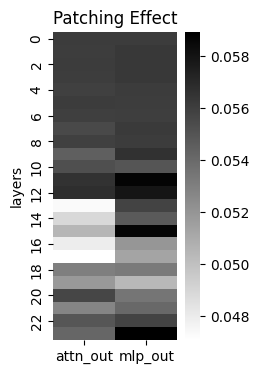

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np


def plot_heatmap(array, title='', xticklabels=["attn_out", "mlp_out"], cmap="binary"):
    titlefont, labelsize=12, 10
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center')
    ax.set_ylabel('layers', fontsize=labelsize)
    plt.show()
    
    
patching_effect = vector_scale.cpu().mean(0)
print(patching_effect.sum(0))
plot_heatmap(patching_effect.numpy(), title='Patching Effect', cmap="binary")

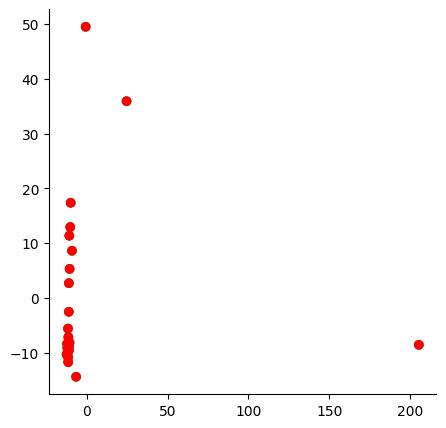

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA

def dim_reduction(embs, reduction="pca"):
    
    x = embs.view(-1, embs.shape[-1]).detach().numpy()
    
    y_len = embs.shape[1]
    y = [0] * y_len + [1] * y_len
    colormap = np.array(['g', 'r'])
    y = colormap[y]
    
    if reduction == "pca":
        pca = PCA(n_components=2)
        x_2D = pca.fit_transform(x)
        
    fig, (ax) = plt.subplots(1, figsize=(5, 5), gridspec_kw={'hspace': 0.40})
    ax.scatter(x_2D[:, 0], x_2D[:, 1], c=y)
    plt.show()
    
dim_reduction(vector_dir.mean(0)[...,0,:].cpu())